In [4]:
!pip install nltk


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [7]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [8]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
true['category'] = 1
false['category'] = 0

In [12]:
df = pd.concat([true,false]) #Merging the 2 datasets

Text(0.5, 1.0, 'Distribution of True and False news in dataset')

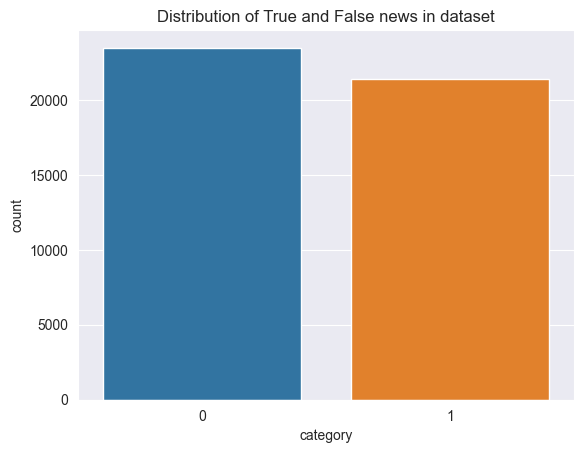

In [20]:
sns.set_style("darkgrid")
sns.countplot(x='category', data=df)
plt.title("Distribution of True and False news in dataset")

In [21]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [22]:
df.title.count()

44898

In [23]:
df.subject.value_counts()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

Text(0.5, 1.0, 'Breakdown by subject')

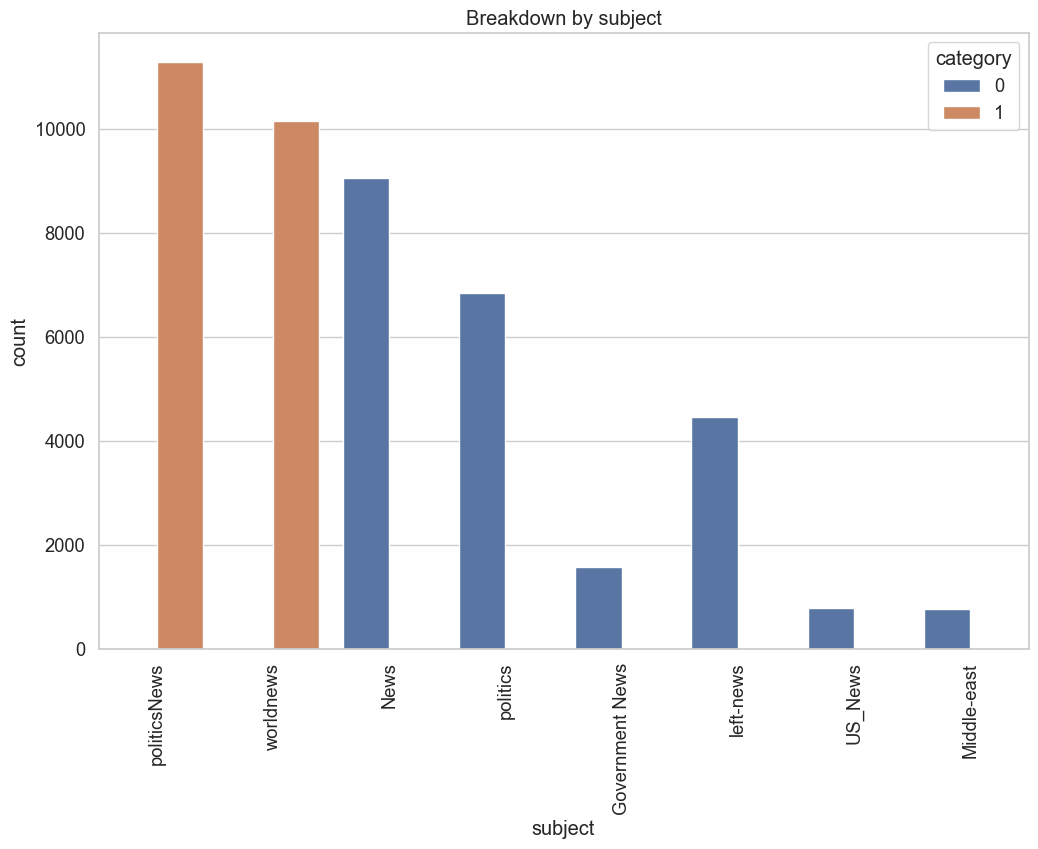

In [25]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.title("Breakdown by subject")

In [26]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [30]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [31]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15720\3988634092.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


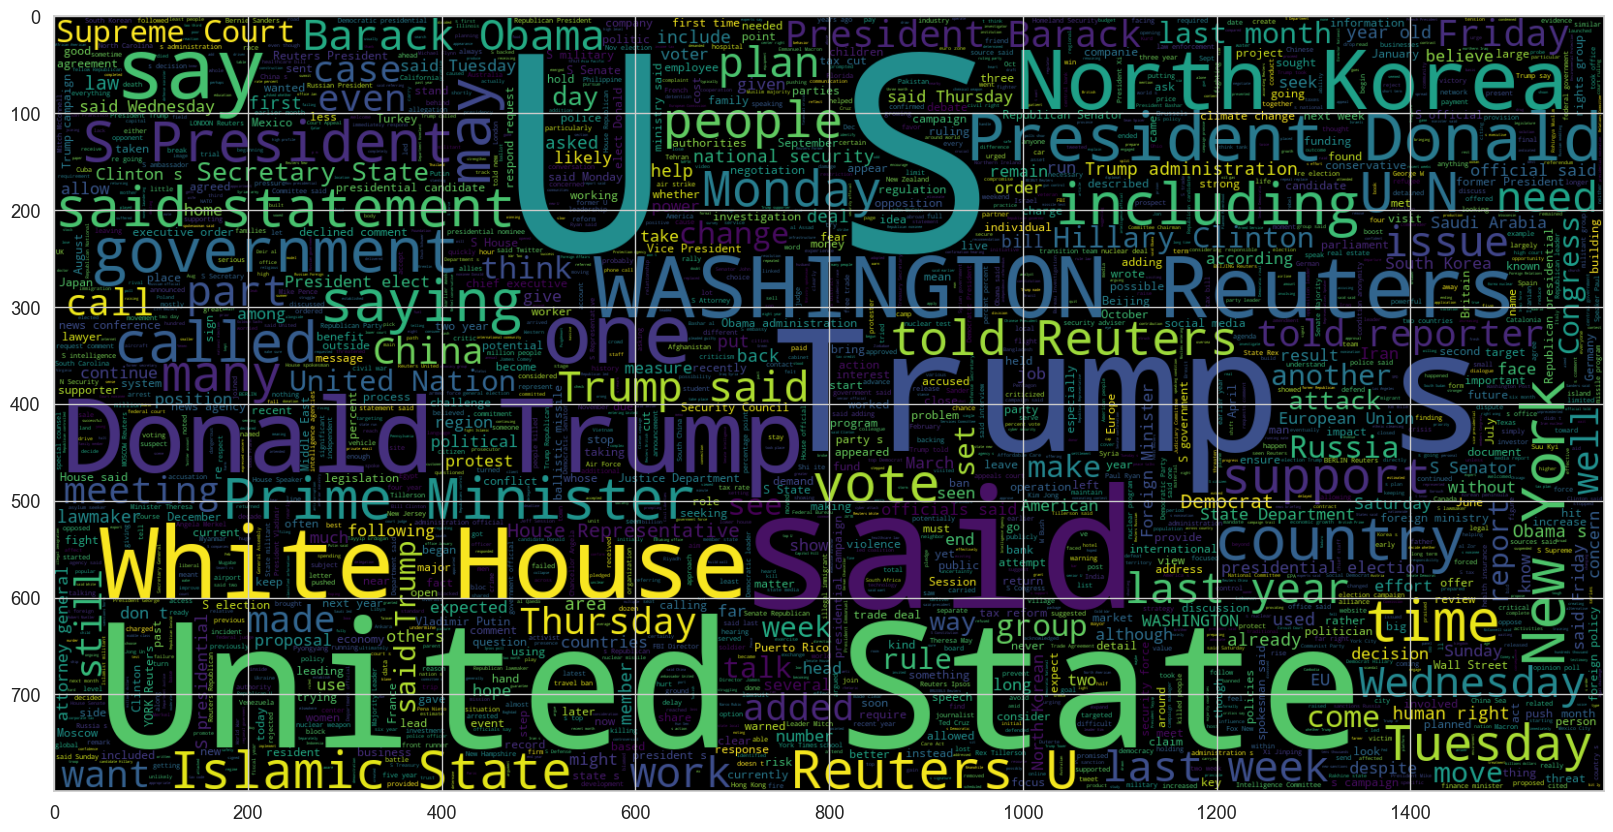

In [32]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

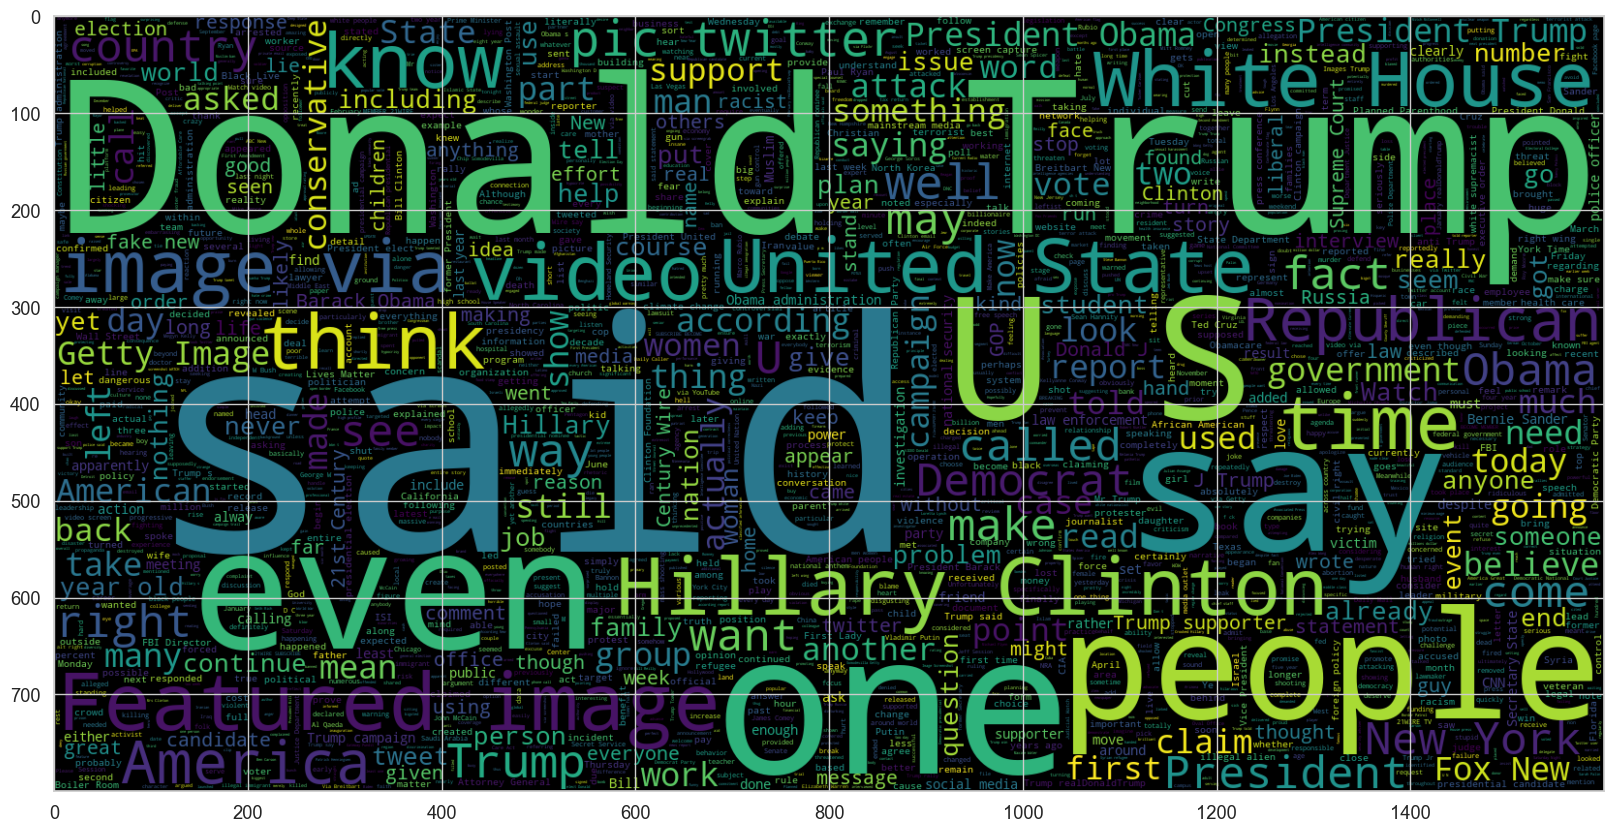

In [33]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

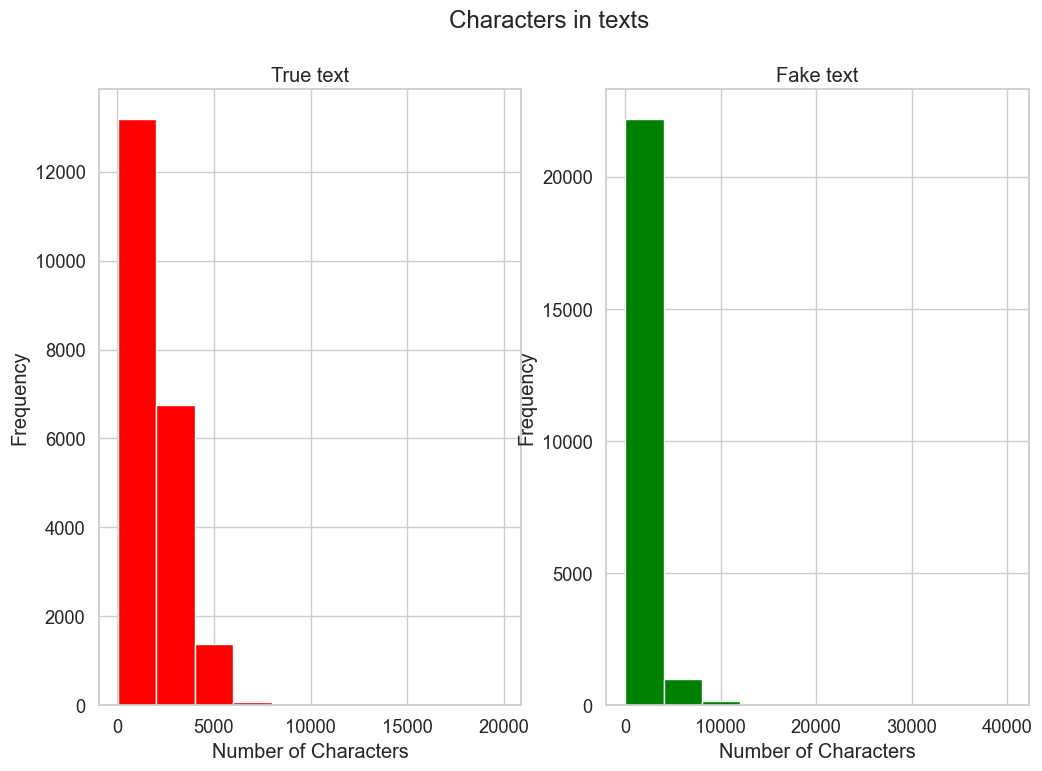

In [35]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('True text')
ax1.set_xlabel('Number of Characters')  # Add x-axis label
ax1.set_ylabel('Frequency')           # Add y-axis label

text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
ax2.set_xlabel('Number of Characters')  # Add x-axis label
ax2.set_ylabel('Frequency')           # Add y-axis label
fig.suptitle('Characters in texts')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15720\2368653048.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15720\2368653048.py:6: UserWarning: 

`distplot` is a

Text(0.5, 0.98, 'Average word length in each text')

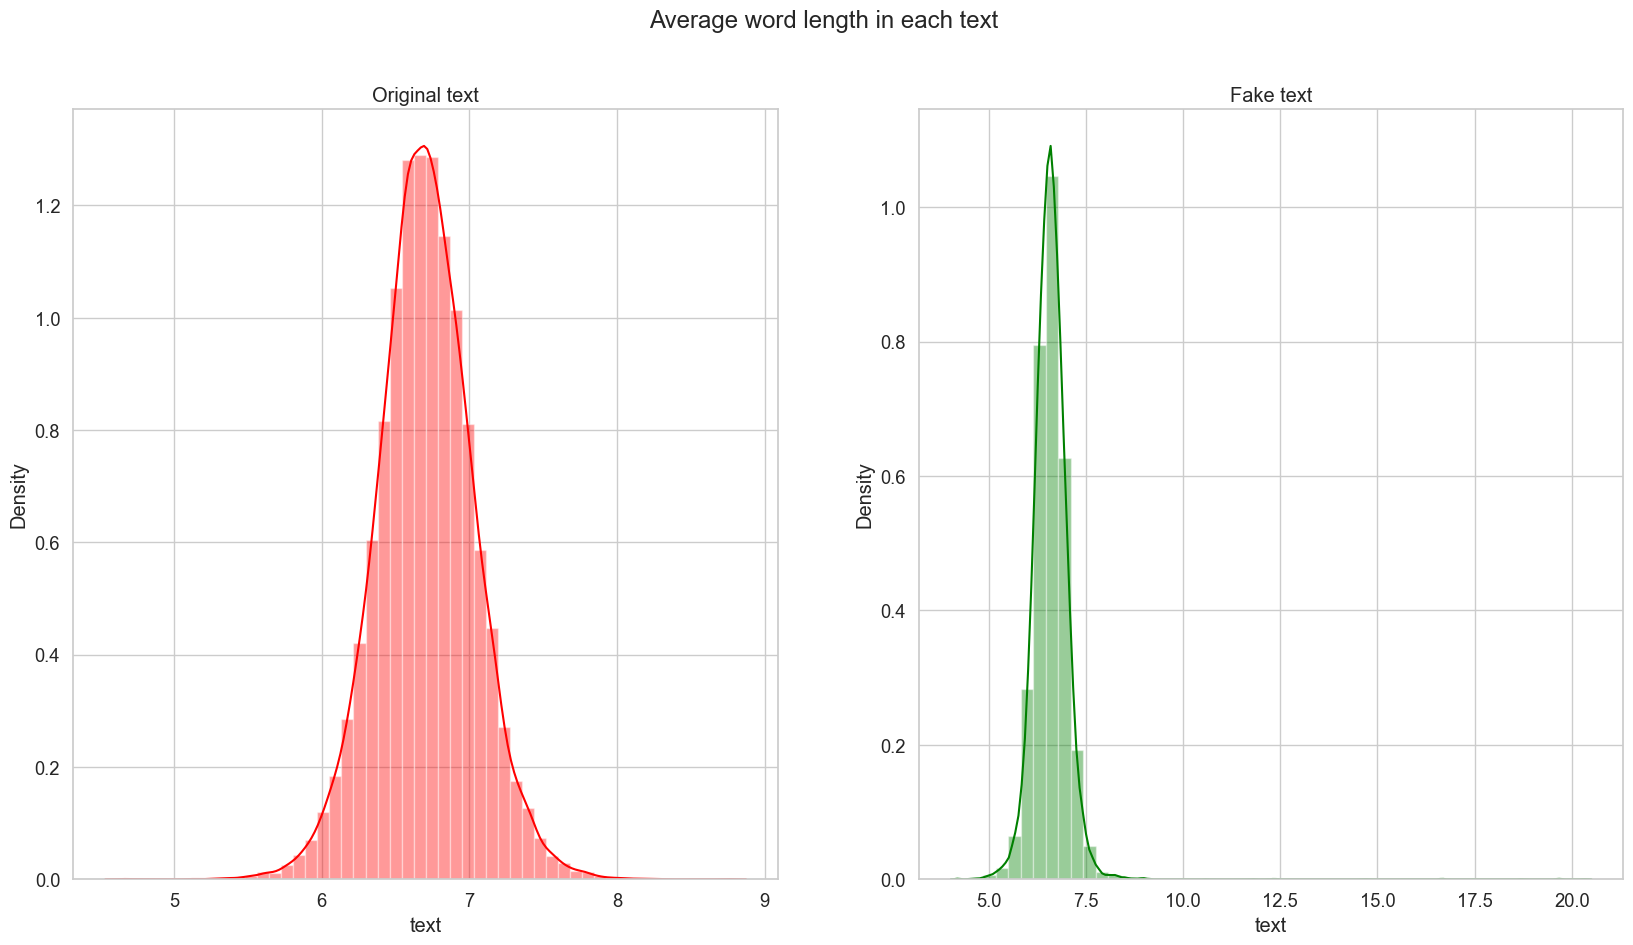

In [36]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [37]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [38]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

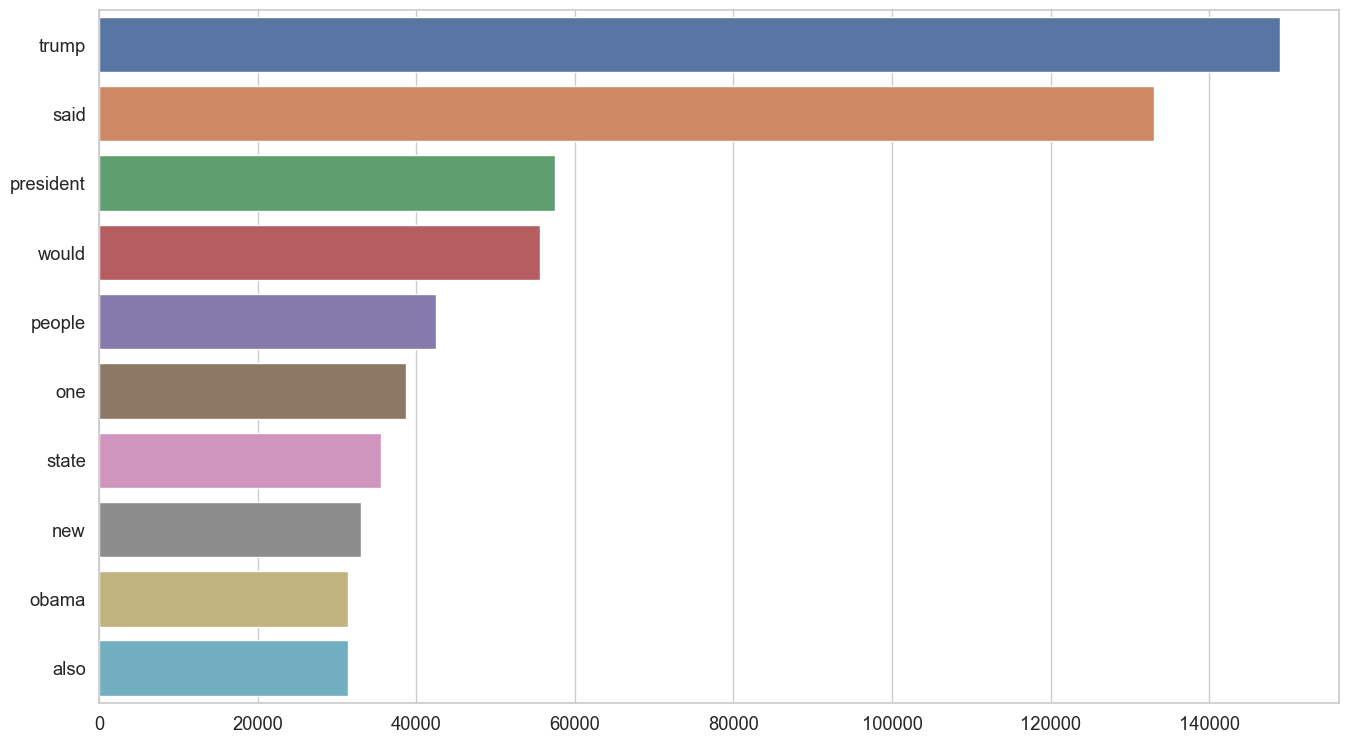

In [40]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

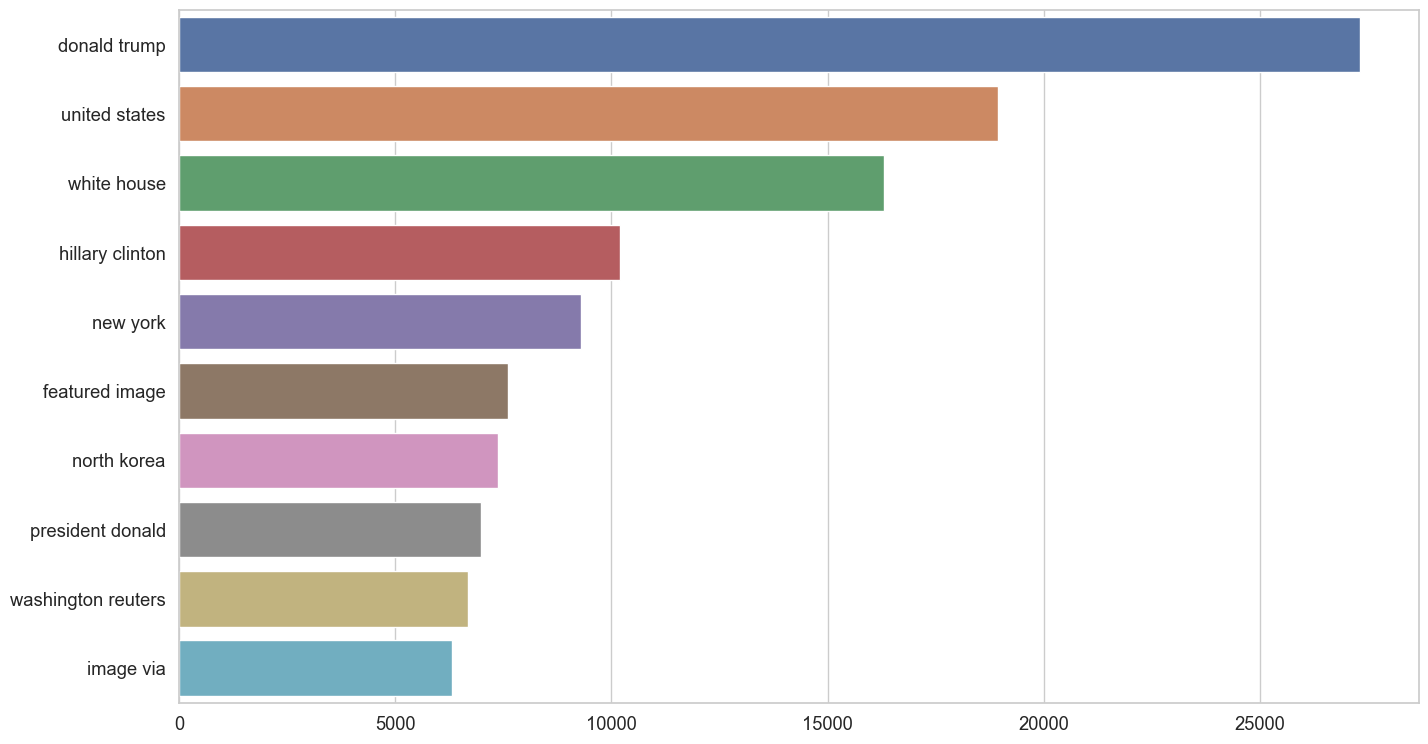

In [41]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

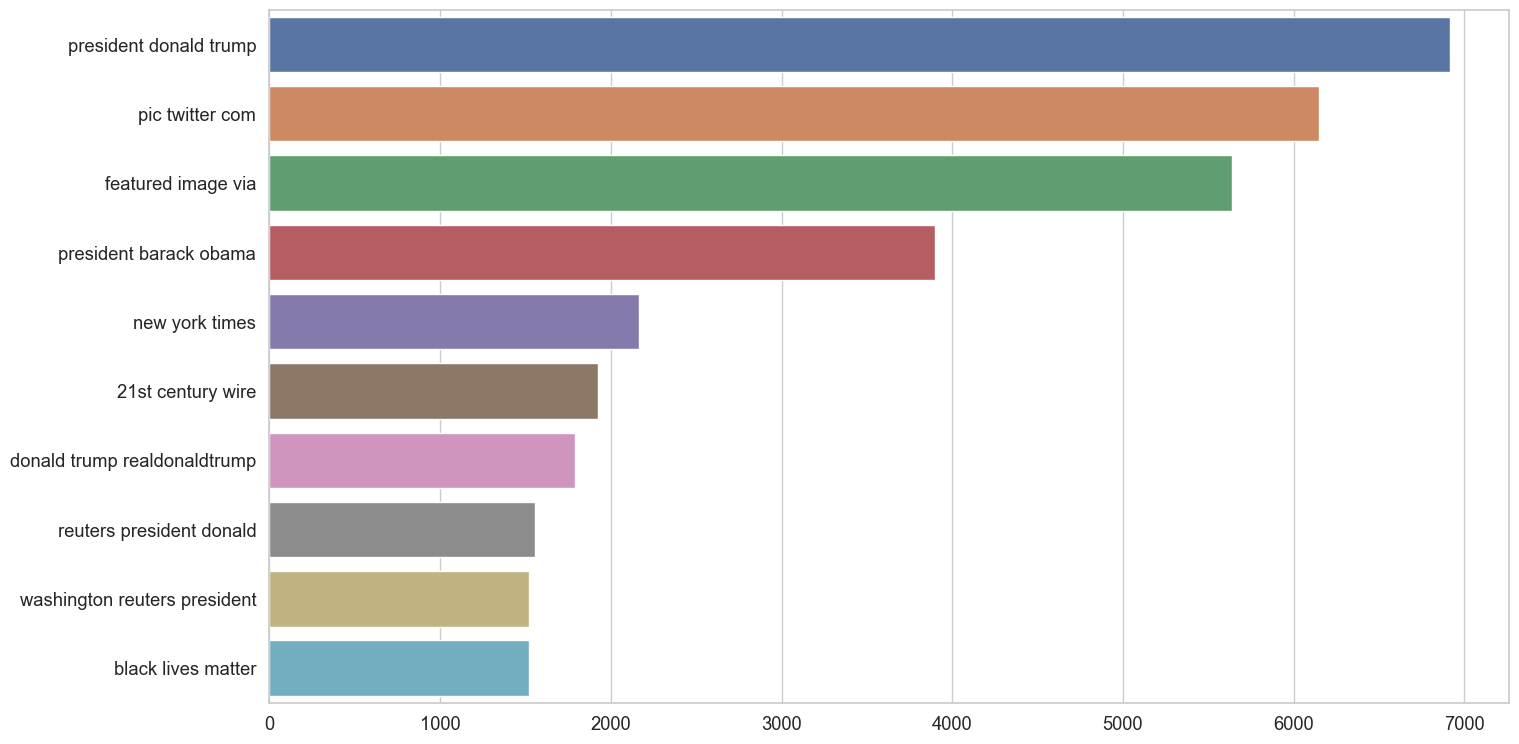

In [42]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))